# P3: Il migliore di tutti

### importo le librerie che mi serviranno

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir( "C:/Users/Rossig/Desktop/Master/Ferrara\ " )
import Funzioni
dir(Funzioni)

['Game',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bayesian_rating',
 'conta_rating',
 'conta_rating_positivi',
 'differenza',
 'math',
 'np',
 'pd',
 'pearsonr',
 'rapporto',
 'similarity',
 'st',
 'unique_values',
 'wilson']

### importo il dataset

In [4]:
df=pd.read_csv("bgg.csv")
len(df)

1082167

Verifico la presenza di valori mancanti

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

game           0
title          0
rating    375354
dtype: int64


La colonna rating presenta 375.534 missing values, li elimino dal dataframe

In [ ]:
df=df.dropna()
df.head()

In [7]:
df.shape

(706813, 3)

Il dataset risultante ha 706.813 righe e 3 colonne

# Algoritmo differenza

Elaboro il primo algoritmo di rating dato dalla differenza tra i positivi e i negativi

$Score = \text{Differenza} ={\text{Positivi - }}{\text{Negativi}}$

In [8]:
Algoritmo1=Funzioni.differenza(df["game"],df["rating"])
Algoritmo1

,game,differenza
0,1,41
1,2,4
2,3,64
3,4,9
4,5,48
...,...,...
23805,305682,18
23806,306494,7
23807,306577,5
23808,308565,11


Algoritmo 1 assegna ad ogni gioco la differenza tra i rating positivi e negativi

# Algoritmo Rapporto

Il secondo algoritmo è dato dal peso dei positivi sui totali

$Score = \text{Rating medio} = \frac{\text{Positivi}}{\text{Totali}}$

In [9]:
Algoritmo2=Funzioni.rapporto(df["game"],df["rating"])
Algoritmo2

,game,rapporto
0,1,0.904110
1,2,0.779412
2,3,0.964286
3,4,0.767123
4,5,0.912500
...,...,...
23805,305682,0.852941
23806,306494,0.842105
23807,306577,1.000000
23808,308565,0.933333


# Limite inferiore dell'intervallo di confidenza di Wilson

\begin{equation}
Score =\frac{\hat{p} + \frac{z^2}{2n} \frac{+}{} z\sqrt{\frac{\hat{p}(1-\hat{p})}{n}+\frac{z^2}{4n^2}}}{1+\frac{z^2}{n}}
\end{equation}

In questa formula, $\hat{p}$ è la proporzione di rating positivi, $n$ è l'ampiezza campionaria, e $z$ è lo $z$-score associato all'intervallo di confidenza scelto (nel caso in esame del 95%).

La formula conta_rating conta tutti i rating raggruppati per game, conta_rating_positivi conta solo quelli maggiori o uguali di 6.
Viene poi creato un DataFrame wilson contenente i valori univoci delle colonne game, totali, positivi.

In [10]:
df=Funzioni.conta_rating(df)
df=Funzioni.conta_rating_positivi(df)
wilson=Funzioni.unique_values(df, ["game","totali","positivi"])

In [11]:
wilson.isna().sum()

game        0
totali      0
positivi    0
dtype: int64

All'interno del DataFrame wilson viene creata una colonna wilson attraverso una funzione che calcola il limite inferiore dell'intervallo di confidenza di Wilson.

In [12]:
wilson["wilson"] = wilson.apply(lambda row: Funzioni.wilson(row['positivi'], row['totali']), axis=1)
wilson

,game,totali,positivi,wilson
0,25984,8,4.0,0.215216
8,103339,59,58.0,0.910043
67,132758,60,57.0,0.862995
127,16497,77,63.0,0.717637
204,195194,47,41.0,0.748261
...,...,...,...,...
706790,11774,8,4.0,0.215216
706798,11781,3,2.0,0.207660
706801,11823,6,6.0,0.609666
706807,11833,1,0.0,0.000000


# Approssimazione Bayesiana

L'approssimazione bayesiana fornisce un modo per assegnare un punteggio a un prodotto quando viene valutato su una scala a K stelle, è definita dalla seguente formula:

$$score = \frac{1}{N+K}\sum_{k=1}^{K}\frac{(k+1)(n_k+1)}{\sum_{j=1}^{K}(n_j+1)} - z \sqrt{\frac{\frac{1}{N+K}\sum_{k=1}^{K}\frac{(k+1)^2(n_k+1)}{\sum_{j=1}^{K}(n_j+1)} - \left(\frac{1}{N+K}\sum_{k=1}^{K}\frac{(k+1)(n_k+1)}{\sum_{j=1}^{K}(n_j+1)}\right)^2}{N+K+1}}$$

dove:

    N rappresenta il numero totale di voti;
    K rappresenta il numero di categorie di valutazione (nel nostro caso i voti da 1 a 10);
    n_k rappresenta il numero di voti per la k-esima categoria di valutazione (numero di voti per la categoria rating=6);
    z rappresenta il valore z della distribuzione normale standard per il livello di confidenza desiderato (95%);

La funzione bayesian_rating viene applicata al dataframe df, i valori vengono poi salvati all'interno del dataframe bayes

In [13]:
bayesian_rating = lambda x: Funzioni.bayesian_rating(x.values)
bayes=pd.DataFrame(df.groupby('game')['rating'].apply(bayesian_rating))
bayes=bayes.rename(columns={'rating': 'rating_bayes'})


## Creo una colonna di ranking per ognuno dei 4 dataframe contenenti i 4 possibili metodi di ranking analizzati

In [14]:
Algoritmo1['ranking_1'] = Algoritmo1['differenza'].rank(ascending=False)
Algoritmo2['ranking_2'] = Algoritmo2['rapporto'].rank(ascending=False)
wilson['ranking_w'] = wilson['wilson'].rank(ascending=False)
bayes['ranking_b'] = bayes['rating_bayes'].rank(ascending=False)

I 4 rating verranno valutati in base alla loro similarità con il ranking reperito da un file kaggle contenente dati sui giochi in scatola bgg (tra cui il ranking)

In [15]:
kaggle=pd.read_csv("bgg_kaggle.csv",sep=";",decimal=",")
kaggle=kaggle.rename(columns={'ID': 'game','BGG Rank': 'ranking_k'})

Ho rinominato le colonne ID come game e BGG Rank ranking_k in così da avere una nomenclatura omogenea con gli altri ranking

In [16]:
kaggle.head()

,game,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,ranking_k,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [17]:
len(kaggle)

20343

Unisco i 5 dataframe

In [18]:
# Unisco i primi due DataFrame
Rank = pd.merge(Algoritmo1, Algoritmo2, on='game')
# Unisco il terzo DataFrame
Rank = pd.merge(Rank, wilson, on='game')
# Unisco il quarto DataFrame
Rank = pd.merge(Rank, bayes, on='game')
#Unisco il quinto
Rank = pd.merge(Rank, kaggle, on='game')

# Seleziono solo le colonne "game" e i cinque ranking
Rank = Rank[['game', 'ranking_1', 'ranking_2', 'ranking_w', 'ranking_b','ranking_k']]
Rank["game"]=Rank["game"].astype(str)
print(Rank.isna().sum())

game         0
ranking_1    0
ranking_2    0
ranking_w    0
ranking_b    0
ranking_k    0
dtype: int64


quanti record ci sono in comune?

In [19]:
count_originale=wilson["game"].nunique()
count_merged = Rank['game'].nunique()
quota=count_merged/count_originale
print("Ci sono {} record (distinti) in comune tra i dataframe analizzati, il {:.1%} di quelli originari".format(count_merged,quota))

Ci sono 17022 record (distinti) in comune tra i dataframe analizzati, il 71.5% di quelli originari


Confronto con ranking_k ritenuto un benchmark i 4 ranking per similarità tramite la funzione similarity

In [20]:
Funzioni.similarity(Rank)

ranking_1 vs ranking_k    75.85
ranking_2 vs ranking_k    72.46
ranking_w vs ranking_k    85.43
ranking_b vs ranking_k    60.94
dtype: float64

Il ranking ottenuto tramite il  Limite inferiore dell'intervallo di confidenza di Wilson risulta essere il migliore in quanto più simile a quello "ufficiale" otttenuto tramite il dataset BGG Rank

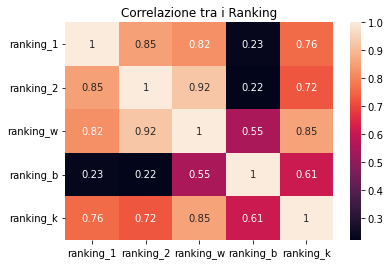

In [21]:
# Calcolo la matrice di correlazione
corr_matrix = Rank.corr(method='pearson')
# Creo una heatmap per visualizzare la matrice di correlazione
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlazione tra i Ranking')
plt.show()

Guardando l'ultima riga del grafico (o colonna) appare evidente come il migliore ranking sia quello di Wilson, seguito dalla differenza e dal rapporto.
Il ranking dato dall'approsimazione bayesiana è si avvicina meno a quello utilizzato da Bgg

# Qual'è il migliore?

Visto che il migliore gioco non dipende da un ranking ma da fattori totalmente soggettivi attraverso la classe Game verranno fatti inserire dall'utente dei parametri che filtreranno il dataset e restituiranno il miglior gioco adatto a lui.

In [22]:
m=Funzioni.Game(kaggle)

In [23]:
m.filter()

Voglio un gioco che sia uscito dopo il: as


ValueError: invalid literal for int() with base 10: 'as'